# Predicting Starcraft 2 players
[Kaggle Starcraft II Prediction Challenge](https://www.kaggle.com/c/insa-5if-2018)

## Initialisation
We will use Python3 with [Numpy](http://www.numpy.org/) for linear algebra, [Pandas](https://pandas.pydata.org/) for data processing and CSV files I/O, and [scikit-learn](https://scikit-learn.org/stable/) for predictions. The environment is defined by the [Kaggle Python docker image](https://github.com/kaggle/docker-python).

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from pandas.plotting import parallel_coordinates,scatter_matrix
import seaborn as sns
import os
import matplotlib.pyplot as plt
import re

## Important Variables

In [2]:
#To be sure that we get all the right keys
CSV_KEYS = ['id', 'class', 's', 'sBase', 'sMineral', 'order']
for i in range(10):
    CSV_KEYS.append('hotkey' + str(i))

#Define map class->value
CLASSES = {}

#Zerg -> 0
#Protoss -> 1
#Terran -> 2
CLASSES['Zerg'] = 0
CLASSES['Protoss'] = 1
CLASSES['Terran'] = 2

#Define Directories
OUTPUT = '../data/output'
OUTPUT_SUB = OUTPUT
OUTPUT_CHARTS = OUTPUT + '/charts/'
INPUT = '../data/input'
INPUT_TRAIN = INPUT + '/TRAIN.CSV'
INPUT_TEST = INPUT + '/TEST.CSV'
INPUT_TRAIN_LONG = INPUT + '/TRAIN_LONG.CSV'

## Reading Data

In [3]:
import csv
from collections import defaultdict
csv_file = '../data/input/TRAIN.CSV'

def get_train_data_():    
    with open(csv_file, newline='') as csv_text:
        cvs_reader = csv.reader(csv_text, delimiter=',')
        data = []
        ids = []

        for row in cvs_reader:

            ids.append(row[0])
            train_dict = defaultdict(int)
            train_dict['id'] = row[0]
            train_dict['class'] = row[1]

            t = 0
            for i in range(1, len(row)-2):
                if 'hotkey' in row[len(row)-i] and t != 0:
                    train_dict[row[len(row)-i][:-1]] += 1/t
                if 't' in row[len(row)-i][0] and t==0:
                    t = int(row[len(row)-i][1:])
            data.append(train_dict)
        return data, ids

def zero_dict():
    new_dict = {}
    #Initialize to zero
    for i in CSV_KEYS:
        new_dict[i] = 0
    return new_dict
        

In [4]:
data, ids= get_train_data()
df = pd.DataFrame(data, columns=data[0].keys()) 
print('Shape of the dataset: ' + str(df.shape))
df.sample(n=5).fillna(0)

Shape of the dataset: (3052, 16)


,id,class,s,sBase,sMineral,order,hotkey0,hotkey1,hotkey2,hotkey3,hotkey4,hotkey5,hotkey6,hotkey7,hotkey8,hotkey9
379,http://eu.battle.net/sc2/en/profile/2910724/1/...,1,0.315183,0.006283,0.000000,1313131313131313131313131313131313131313131313...,0.057592,0.914136,0.089005,0.573822,0.434555,0.000000,0.000000,0.000000,0.004188,0.003141
2028,http://eu.battle.net/sc2/en/profile/3533538/1/...,1,0.402312,0.018497,0.002312,1414141414141143414141414141141144114141343443...,0.000000,0.360694,0.099422,0.495954,0.417341,0.031214,0.001156,0.001156,0.000000,0.000000
738,http://us.battle.net/sc2/en/profile/5393959/1/...,0,1.233333,0.069048,0.000000,1111511616111116115115515111111112111111115512...,0.002381,0.263095,0.084524,0.104762,0.076190,0.317857,0.023810,0.003571,0.005952,0.007143
118,http://eu.battle.net/sc2/en/profile/3538115/1/...,0,1.005525,0.023204,0.000000,1601601160160116011616016016016160601601601116...,0.822099,0.632044,0.059669,0.008840,0.000000,0.000000,1.004420,0.008840,0.000000,0.137017
1602,http://eu.battle.net/sc2/en/profile/3973341/1/...,1,0.502488,0.004975,0.002985,3233131632313633162626262622161633213236363236...,0.040796,0.366169,0.469652,0.314428,0.174129,0.000000,0.990050,0.027861,0.022886,0.000000


In [65]:
print(data[561])

{'id': 'http://us.battle.net/sc2/en/profile/2735594/1/coLqxc/', 'class': 2, 's': 0.2, 'sBase': 0, 'sMineral': 0.1, 'order': '1', 'hotkey0': 0, 'hotkey1': 0.1, 'hotkey2': 0, 'hotkey3': 0, 'hotkey4': 0, 'hotkey5': 0, 'hotkey6': 0, 'hotkey7': 0, 'hotkey8': 0, 'hotkey9': 0}


# EDA ( Exploratory Data Analysis) 

## Nombre de parties par joueur

In [8]:
df.groupby('id').id.count().reset_index(name='count').sort_values('count',ascending=True).sample(n=5)
df.iloc[20].id


'http://eu.battle.net/sc2/en/profile/250458/1/VortiX/'

Mauvaise répartion des parties pour chaque joueur. Certains ont joués que 4 parties alors que d'autres 50. Comment résoudre cela ? ==> SMOTE ? ADASYN ? permet de over-sampling !!!

In [8]:
df.groupby('id').id.count().reset_index(name='count').sort_values('count',ascending=False).describe()


,count
count,200.00000
mean,15.26000
std,10.41464
min,4.00000
25%,7.00000
50%,12.00000
75%,20.00000
max,58.00000


## Nombre de joueur

In [14]:
nb_joueur = list(dict.fromkeys(ids))
print(len(nb_joueur))

200


In [10]:
nb_joueur = list(dict.fromkeys(ids))
print(nb_joueur)

['http://eu.battle.net/sc2/en/profile/4234852/1/First/', 'http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/', 'http://eu.battle.net/sc2/en/profile/3401218/1/Welmu/', 'http://eu.battle.net/sc2/en/profile/2896854/1/MÇ‚ForGG/', 'http://eu.battle.net/sc2/en/profile/3538115/1/Golden/', 'http://eu.battle.net/sc2/en/profile/250458/1/VortiX/', 'http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/', 'http://eu.battle.net/sc2/en/profile/2452136/1/MinChul/', 'http://eu.battle.net/sc2/en/profile/2222468/1/dTefel/', 'http://eu.battle.net/sc2/en/profile/4341883/1/Patience/', 'http://eu.battle.net/sc2/en/profile/950504/1/Grubby/', 'http://eu.battle.net/sc2/en/profile/2898004/1/MMA/', 'http://eu.battle.net/sc2/en/profile/251061/1/LiveZerg/', 'http://eu.battle.net/sc2/en/profile/1021189/1/Dayshi/', 'http://eu.battle.net/sc2/en/profile/326029/1/LiquidTLO/', 'http://eu.battle.net/sc2/en/profile/1058669/1/Happy/', 'http://eu.battle.net/sc2/en/profile/1139573/1/BabyKnight/', 'http://eu.battle.net/

## Repartition des races

On essaye de comprendre l'influence de la race sur le joueur : il y a t-il des joueurs qui change de champion ?

Protoss    1210
Zerg       1061
Terran      781
Name: class, dtype: int64


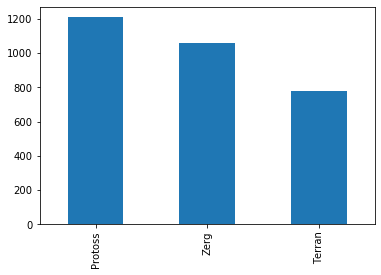

In [11]:
races = df['class'].value_counts()
print(races)
races.plot.bar()

In [37]:
df.groupby(['class','id'])['id'].count()

class  id                                                         
0      http://eu.battle.net/sc2/en/profile/1173786/1/VPbenQsLivko/    12
       http://eu.battle.net/sc2/en/profile/2048063/1/AcerBly/         13
       http://eu.battle.net/sc2/en/profile/2101268/1/Stephano/        12
       http://eu.battle.net/sc2/en/profile/2115876/1/FireCake/        16
       http://eu.battle.net/sc2/en/profile/219517/1/TargA/             7
                                                                      ..
2      http://xx.battle.net/sc2/en/profile/405/1/MMA/                  4
       http://xx.battle.net/sc2/en/profile/406/1/INnoVation/           4
       http://xx.battle.net/sc2/en/profile/408/1/Polt/                 6
       http://xx.battle.net/sc2/en/profile/410/1/STBomber/            15
       http://xx.battle.net/sc2/en/profile/413/1/Maru/                15
Name: id, Length: 200, dtype: int64

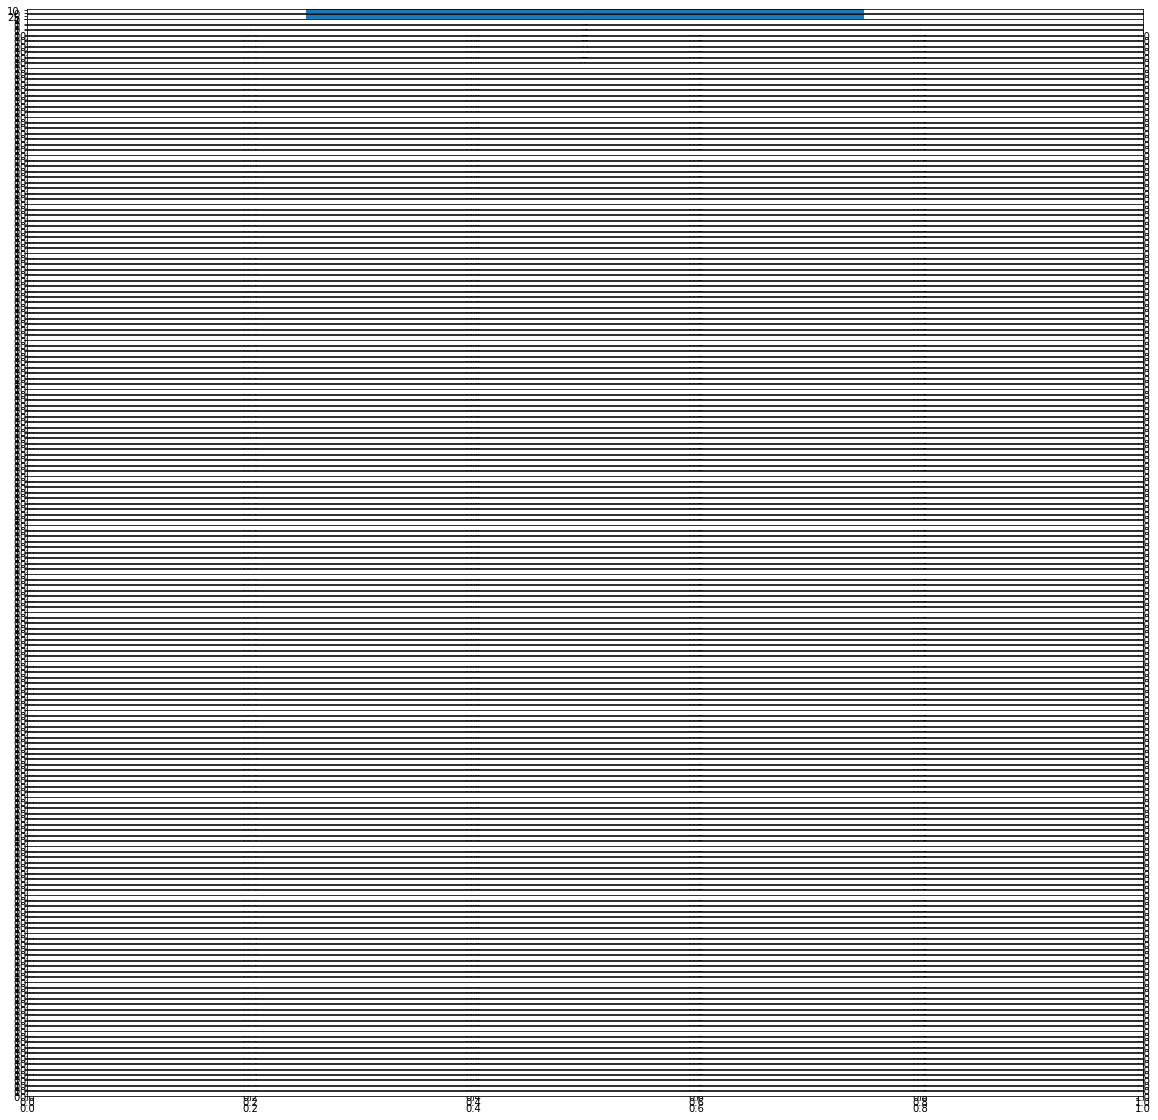

In [16]:
f,ax=plt.subplots(200,1,figsize=(20,20))
dfi = df.set_index("id")


for i in range (0,2) :
    races_joueur = dfi.loc[nb_joueur[i]]['class'].value_counts()
    races_joueur.plot.bar(ax=ax[i])
    
    
plt.show()  

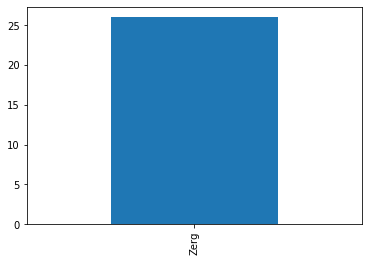

In [14]:
races_joueur = dfi.loc[ids[100]]['class'].value_counts()
races_joueur.plot.bar()

### Remarque : Chaque joueur ne joue qu'un seul type de personnage ( ligne droite pas de déviation). Donc cette feature est très importante pour nous. !!!!!

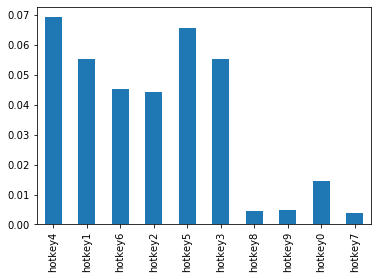

In [15]:
df.var().plot.bar()

on pourrait supprimer les hotckey 8,9 , 0 ,7 car ils sont très peu fréquents ( biais pour la classification)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019F4B7B3D48>,
      dtype=object)

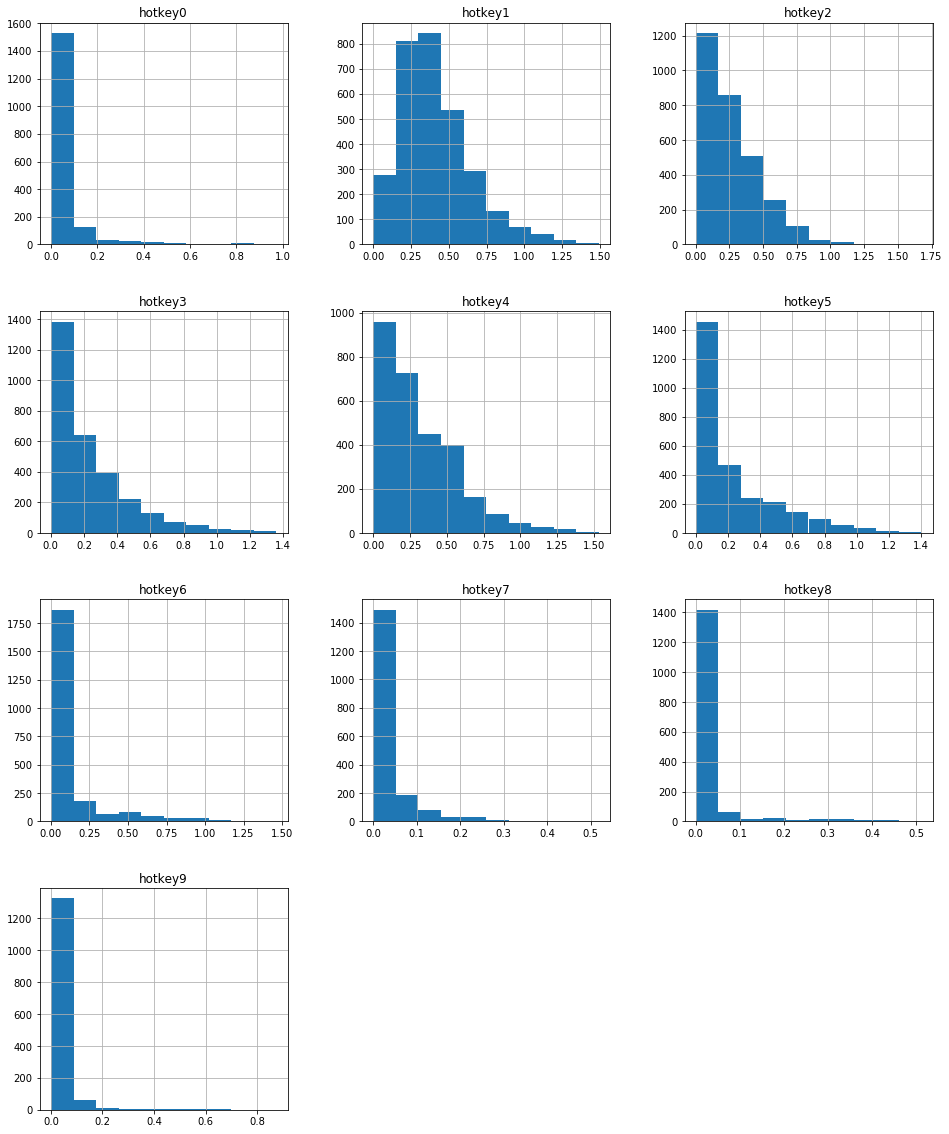

In [16]:
df.hist(figsize = (16,20), stacked= False)

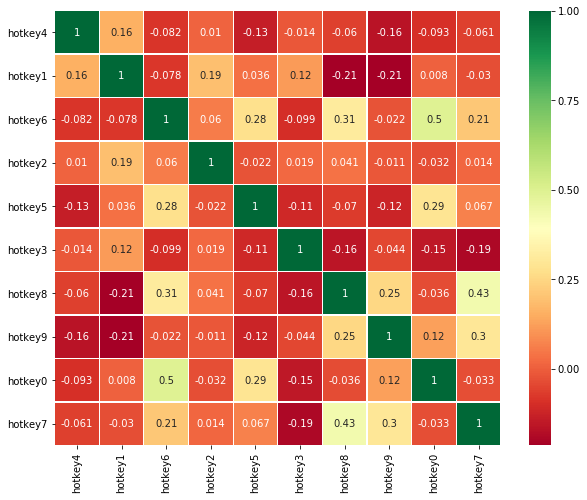

In [17]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

Les corrélations ne sont pas suffisante pour pouvoir appliquer une supprésion de features. les features sont tous bien corrolé . Voir avec race ??